<h1> MPH Thesis Scribbles </h1>
<h2> The Climate </h2>

---

Welcome to the second installation of Thesis Scribbles by Lillian, the series where I document my casual exploratory data analysis in pursuit of a testable hypothesis for my MPH capstone!

My over-arching goal is to create a predictive model of respiratory disease incidence at the county-level. In the last installment I compared flu-symptom Google Trends data in Grand Rapids to Influenza-Like Illness (ILI) incidence in Kent County. In this installment, I will take a look at historical Air Quality Index (AQI) measurements in Kent County.

---

In light of the Canadian wildfires that impacted the state of Michigan this summer, I find myself wondering what - if any - effect will that have on ILI incidence this winter? There's literature suggesting that increased air pollutants during wildfire season is associated with an increase in respiratory illness 8-10 weeks later. If this is indeed happening in Michigan, then AQI may be a useful parameter in a predictive model of respiratory diseases.

Let's instantiate our Jupyter environment and import necessary python modules to get started.

In [10]:
import pandas as pd
from datetime import datetime
import plotly.express as px
from sklearn import preprocessing
import numpy as np

The EPA has daily, county-level AQI data available here. These data are available via an API, and in addition, pregenerated csv files are available to download. I chose to download the files this time.

Each csv file has one year of daily AQI measurements for all US counties, totaling to over 250,000 rows in each file. I downloaded 23 years of AQI measurements, so I had a LOT of data to dig through. I wrote two functions to manage this task.

The preprocess() function intakes a dataframe made from one csv data file. It filters the dataframe to select, reformat, and return Kent County data.

The process() function intakes a list of dataframes (one from each year-csv file), runs each through the preprocess() function before calculating monthly mean AQIs and concatenating everything into a single output dataframe.

The result is one dataframe containing the average AQI for each month between 2000-2022 for Kent County, Michigan. 

In [11]:
def preprocess(df):
    df = df.loc[df['State Name']=='Michigan']
    df = df.loc[df['county Name']=='Kent']
    df['time'] = pd.to_datetime(df['Date'])
    df['year'] = df['time'].apply(lambda x: x.year)
    df['month'] = df['time'].apply(lambda x: x.month)
    return df

def process(df_list=[]):
    output = pd.DataFrame()
    output = pd.concat([preprocess(df).groupby(['year','month'])['AQI'].mean() for df in df_list])
    return(output)

In [12]:
ldl = []

for i in range(2000,2023):
    ldl.append(pd.read_csv("c:\\Users\\ljens\\OneDrive\\Documents\\MSU MPH\\capstone\\AQI\\daily_aqi_by_county_"+str(i)+".csv", low_memory=False))

In [13]:
yay = pd.DataFrame(process(ldl))

In [14]:
yay.head()

AQI
year month           
2000 1      57.258065
     2      61.413793
     3      47.967742
     4      53.033333
     5      57.935484

In [15]:
yay.reset_index(inplace=True)
yay['time']=pd.to_datetime(yay['month'].astype('str') + '-' + yay['year'].astype('str'))


Let's take a peek at how these data look.

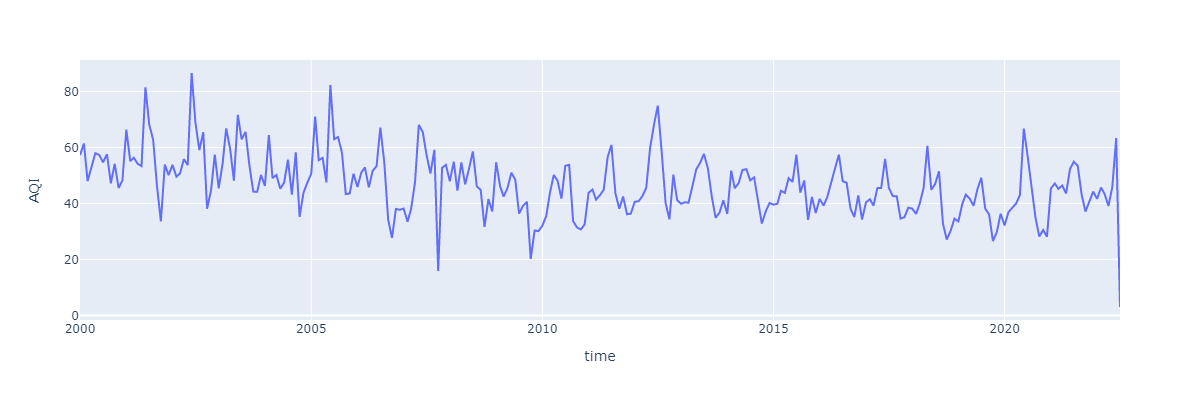

In [16]:
fig = px.line(yay, x='time',y='AQI', width=1200, height=400)
fig.show('png')

We can definitely see the rise and fall of air pollution alongside wildfire season. 

Let's normalize these data, then plot them together with normalized ILI incidence data from the county

In [17]:
dd = pd.read_csv("C:\\Users\\ljens\\OneDrive\\Documents\\MSU MPH\\Practicum\\older dates\\data.csv")

In [18]:
flu = dd.loc[dd['Disease Group'] == 'InfluenzaInfluenzaInfluenzaInfluenza']
flu = flu[['Time','Count','Year']]
flu['Time'] = pd.to_datetime(flu['Time'])
flu['Count'] = flu['Count'].astype('int')
flu['Month'] = flu['Time'].apply(lambda x: x.month)
flu.head()

,Time,Count,Year,Month
21,2012-01-01,6609,2012,1
54,2012-02-01,7066,2012,2
87,2012-03-01,9728,2012,3
120,2012-04-01,4698,2012,4
153,2012-05-01,3449,2012,5


In [19]:
yay.rename(columns={'time':'Time'}, inplace=True)
yay['scale'] = preprocessing.minmax_scale(yay['AQI'])

In [20]:
flu['flu'] = preprocessing.StandardScaler().fit(np.array(flu['Count']).reshape(-1,1)).transform(np.array(flu['Count']).reshape(-1,1))
flu.set_index('Time', inplace=True)

yay['Air Quality'] = preprocessing.StandardScaler().fit(np.array(yay['AQI']).reshape(-1,1)).transform(np.array(yay['AQI']).reshape(-1,1))
yay.set_index('Time', inplace=True)

df = pd.DataFrame()
df['Flu'] = flu['flu']
df['Pollution'] = yay['Air Quality']
df = pd.melt(df.reset_index(), id_vars='Time', value_vars=['Flu','Pollution'], value_name='value',var_name='Variables')
df = df.loc[df['Time']<datetime(month=1, day=1, year=2020)]

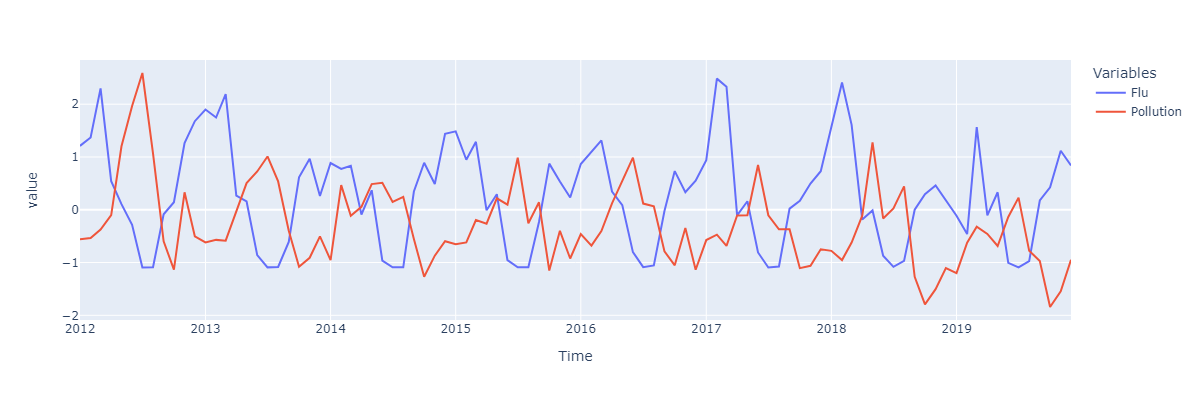

In [22]:
fig = px.line(df.drop_duplicates(), x='Time',y='value',color='Variables', width=1200, height=400)
fig.show('png')

Interestingly, air pollution and ILI incidence seem to be in almost perfect antiphase with each other, with peaks in air pollution preceding flu peaks by about 4-5 months. Could increased air pollution in the summer contribute to higher ILI incidence in the winter? Weekly data on AQI and ILI incidence may show a clearer picture of this possible association